In [11]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

from sklearn.decomposition import PCA


In [12]:
pd.options.display.max_rows = 100
pd.options.display.float_format = '{:.3f}'.format
pd.options.display.max_columns = 100

In [ ]:
bucket = 'leaseplan-oct-2019-ml-immersion'
prefix = 'lease-plan'
filename = 'sample_data.csv'
s3_fullpath = os.path.join('s3://', bucket, prefix, 'raw-data', filename)

!aws s3 cp $s3_fullpath .

In [23]:
# Read from S3 or local
raw_data = pd.read_csv(filename, header=0, sep=',')


########################
# Drop list of iobjectid that has corrupted data
########################
iobjectid = [161541]
raw_data = raw_data[~raw_data['iobjectid'].isin(iobjectid)]
raw_data.reset_index(inplace=True)
print(raw_data.shape)

s3://wy-sandbox-singapore/lease-plan/raw-data/sample_data.csv
(62, 30)


## Helper functions

In [24]:
def get_col_with_null(df):
    series = raw_data.isnull().sum()
    null_col = series[series != 0].index
    
    return list(null_col)




def data_transformation(df):
    
    raw_data = df.copy()
    print(f'Initial data shape: {raw_data.shape}')
    

    # replace null col with 0
    col_with_null = get_col_with_null(raw_data)
    raw_data[col_with_null] = raw_data[col_with_null].fillna(0) 
    
    num_features = raw_data.select_dtypes(exclude='object').columns
    cat_features = raw_data.select_dtypes(include='object').columns

    assert(len(cat_features)+len(num_features) == len(raw_data.columns))
    
    # Column to be dropped
    drop_columns = ['serviceorderid', # grouping info has been implicited used during feature engineering
                    'iobjectid', # does not tell much info, drop for now
                    'customertopnode', # highly corrected to iobjectid
                    'serviceinterval', # highly Correlated to serviceorderid 
                    'terminationflag', #single value: "#"
                     'terminationtype', #single value: "not assigned"
                     'vehicledesc', # text is ignored for now, embedding can be done
                     'accountingindicator', #single value: "budget"
                    ]
    
    
    ########################
    # Feature engineering
    ########################
    # Take 1st 2-digits of post code
    raw_data['supplierpostcode'] = raw_data['supplierpostcode'].apply(lambda x: int(x / 100))
        
    # Check that by grouping 'serviceorderid', the total cost is equal to 'totalcostbyserviceorder'
    raw_data_gb = raw_data.groupby('serviceorderid')['costexcgst']

    total_cost_df = pd.DataFrame(raw_data_gb.sum())
    total_cost_df.columns = ['totalcost_check']

    raw_data = raw_data.merge(total_cost_df, on='serviceorderid')
    raw_data['unmatched_total'] = np.where((raw_data['totalcostbyserviceorder'] - raw_data['totalcost_check']).astype(int) != 0, 1, 0)
    raw_data['cost_ratio'] = raw_data['costexcgst'] / raw_data['totalcostbyserviceorder']

    # Extract numerical quantity without unit
    raw_data['quantity'] = raw_data['quantity'].str.extract('(\d+)')
    raw_data['quantity'] = raw_data['quantity'].fillna(1)

    # treat these as categorical instead of numerical, 
    num_to_cat_col = ['supplierpostcode','industry_code']
    cat_to_num_col = ['quantity']
    

    # update date column to datetime types
    raw_data['jobdate'] = pd.to_datetime(raw_data['jobdate'])
    raw_data['contractstartdateorig'] = pd.to_datetime(raw_data['contractstartdateorig'])
    raw_data['contractenddate'] = pd.to_datetime(raw_data['contractenddate'])
    raw_data['lastknownododate'] = pd.to_datetime(raw_data['lastknownododate'])
    raw_data['builddate'] = pd.to_datetime(raw_data['builddate'])

    date_col = list(raw_data.select_dtypes('datetime64').columns)
    print(f'Date col: {date_col}\n')
    
    # Contract duration
    duration_day = raw_data['contractenddate'] - raw_data['contractstartdateorig']
    raw_data['contract_duration_days'] = duration_day.map(lambda x: x.days)   
    
    # Car ages
    car_age_days = pd.datetime.now() - raw_data['builddate']
    raw_data['car_age_days'] = car_age_days.map(lambda x: x.days)


    ########################
    # New feature to be added
    ########################
    new_num_col = ['contract_duration_days','car_age_days','cost_ratio']
    new_cat_col = ['unmatched_total']
    
    
    ########################
    # Columnn name tracking
    ########################
    final_num_features = list(set(num_features) - set(num_to_cat_col) - set(drop_columns))
    final_num_features = final_num_features + new_num_col + cat_to_num_col
    print(f'Num features: {final_num_features}\n')

    final_cat_features = list(set(cat_features) - set(date_col) - set(cat_to_num_col) - set(drop_columns))
    final_cat_features = final_cat_features + new_cat_col + num_to_cat_col
    print(f'Catogorial features: {final_cat_features}\n')

    raw_data[final_cat_features] = raw_data[final_cat_features].apply(lambda x: x.astype('category'))
    raw_data[final_num_features] = raw_data[final_num_features].apply(lambda x: x.astype('float'))

    data = raw_data[final_num_features+final_cat_features]
    
    ########################
    # Onehot for categorical column
    ########################
    data = pd.get_dummies(data, prefix_sep='_', drop_first=True)
    data = data.astype('float')

    
    ########################
    # Standardization
    ########################
    scaler = MinMaxScaler()
    data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
    
    pca = PCA(n_components=2)
    pca_df = pd.DataFrame(pca.fit_transform(data_scaled), columns=['pca1','pca2'])  
    data_scaled = pd.concat([data_scaled, pca_df], axis=1)

    print(f'New data shape: {data_scaled.shape}')


    return data_scaled


def plot_anomaly(df):
    """Plot pca1/pca2 column with anomaly colormap"""
    
    temp = df.sort_values(['anomaly'], ascending=True)

    fig, ax = plt.subplots(figsize=(10,5))

    cm = {0:'green', 1:'red'}
    ax.scatter(x=temp['pca1'], y=temp['pca2'], c=temp['anomaly'].apply(lambda x: cm[x]))
    plt.show()
    
    

## Data Transformation


In [46]:
new_data = data_transformation(raw_data)
new_data.shape

Initial data shape: (62, 30)
Date col: ['jobdate', 'contractstartdateorig', 'contractenddate', 'lastknownododate', 'builddate']

Num features: ['totalcostbyserviceorder', 'odometer', 'labourcost', 'supplier_srt', 'partscost', 'costexcgst', 'index', 'contract_duration_days', 'car_age_days', 'cost_ratio', 'quantity']

Catogorial features: ['servicetype', 'bodytype', 'contractserviceitem', 'productshorttext', 'make', 'industry_desc', 'model', 'unmatched_total', 'supplierpostcode', 'industry_code']

New data shape: (62, 46)


(62, 46)

In [47]:
new_data.head()

,totalcostbyserviceorder,odometer,labourcost,supplier_srt,partscost,costexcgst,index,contract_duration_days,car_age_days,cost_ratio,quantity,servicetype_Wear & Tear,bodytype_Station Wagon,bodytype_Van,contractserviceitem_Misc Operating Costs Budget,contractserviceitem_Service Plan,productshorttext_DIFF OIL,productshorttext_ENGINE OIL,productshorttext_ENVIRONMENTAL LEVY,productshorttext_FUEL FILTER,productshorttext_GEAR OIL,productshorttext_GLOBE - BRAKE LIGHT RIGHT,productshorttext_OIL FILTER,productshorttext_SCH_SRV_TOYOTA_061,productshorttext_SERVICE BRAKE FLUID,productshorttext_SPARK PLUGS,productshorttext_TOYOTA ADVANTAGE SERVICE,productshorttext_TRAILER PLUG,productshorttext_VEHICLE INSPECTION,productshorttext_WASHER - SUMP PLUG,productshorttext_WASHER ADDITIVE,productshorttext_WHEEL ALIGNMENT - TOE,productshorttext_WHEEL BALANCE X 2,productshorttext_WORKSHOP SUPPLIES,make_Toyota,industry_desc_Services: Social Services,industry_desc_Transport and Communications: Electricit,model_Hiace,model_Hilux,unmatched_total_1,supplierpostcode_30,supplierpostcode_45,industry_code_4049.0,industry_code_8083.0,pca1,pca2
0,0.289,0.390,0.000,0.000,0.009,0.009,0.000,0.000,0.000,0.010,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,-0.237,0.165
1,0.289,0.390,0.000,0.000,0.000,0.000,0.010,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,-0.245,0.165
2,0.289,0.390,0.000,0.000,0.056,0.056,0.020,0.000,0.000,0.061,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,-0.203,0.177
3,0.289,0.390,0.500,0.500,0.000,0.462,0.030,0.000,0.000,0.504,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,1.442,-0.160
4,1.000,0.514,0.000,0.000,0.183,0.183,0.040,0.000,0.000,0.064,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.000,1.000,0.000,0.000,-0.190,-0.152


## Algorithm 1 - EllipticEnvelope

In [49]:
# Save training file
train_filename = 'train_v2.csv'
new_data.iloc[:, :-2].to_csv(train_filename, header=None, index=None)

In [39]:
outliers_fraction = 0.05
envelope =  EllipticEnvelope(contamination=outliers_fraction, 
                             random_state=10,
                            ) 

# Exclude pca columns
X_train = new_data.iloc[:, :-2].values
print(X_train.shape)
envelope.fit(X_train)


(62, 44)


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/covariance/robust_covariance.py:646: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "


EllipticEnvelope(assume_centered=False, contamination=0.05, random_state=10,
         store_precision=True, support_fraction=None)

In [40]:
df_result_EE = raw_data.copy()
df_result_EE['deviation'] = envelope.decision_function(X_train)
df_result_EE['anomaly'] = envelope.predict(X_train)
df_result_EE['anomaly'] = np.where(df_result_EE['anomaly'] == 1, 0, 1)

df_result_EE[df_result_EE['anomaly']==1]

,index,iobjectid,jobdate,terminationflag,terminationtype,contractstartdateorig,contractenddate,lastknownododate,builddate,customertopnode,make,model,vehicledesc,bodytype,serviceorderid,accountingindicator,serviceinterval,odometer,supplierpostcode,industry_desc,industry_code,contractserviceitem,servicetype,productshorttext,quantity,supplier_srt,partscost,labourcost,costexcgst,totalcostbyserviceorder,deviation,anomaly
15,15,161531,26JUL2011,#,Not assigned,23OCT2009,22OCT2012,06SEP2012,01SEP2009,1000004617,Toyota,Hiace,Hiace 2.7P LWB Van A,Van,2801369140,Budget,80000.000,80328,4551,Construction: Building - General Contrac,1515.000,Maintenance Budgeted Premium,Wear & Tear,FUEL FILTER,1 ST,0.000,142.710,0.000,142.710,405.410,-28.994,1
47,47,161531,11APR2012,#,Not assigned,23OCT2009,22OCT2012,06SEP2012,01SEP2009,1000004617,Toyota,Hiace,Hiace 2.7P LWB Van A,Van,2801881685,Budget,nan,110752,4551,Construction: Building - General Contrac,1515.000,Misc Operating Costs Budget,Wear & Tear,TRAILER PLUG,1 ST,1.000,16.700,82.500,99.200,99.200,-6478.530,1
60,60,161538,29AUG2012,#,Not assigned,04SEP2008,03NOV2012,04SEP2012,01APR2008,1000004428,Holden,Astra,AH Astra CD 5dr Wago,Station Wagon,2802136575,Budget,nan,38048,3043,Services: Social Services,8083.000,Maintenance Budgeted Premium,Wear & Tear,GLOBE - BRAKE LIGHT RIGHT,1 ST,0.200,3.760,15.600,19.360,19.360,-3157.413,1
61,99,161550,05MAY2011,#,Not assigned,26MAY2008,25MAY2012,01APR2015,01DEC2007,1000003639,Toyota,Hilux,Hilux 4WD 4.0P SR DC,Pick-Up,2800297501,Budget,50000.000,52712,2526,Transport and Communications: Electricit,4049.000,Maintenance Budgeted Premium,Scheduled,ENGINE OIL,1 L,0.000,33.000,0.000,33.000,159.260,-5540.689,1


In [41]:
new_data['anomaly'] = df_result_EE['anomaly']
new_data[new_data['anomaly']==1]


,partscost,supplier_srt,costexcgst,odometer,totalcostbyserviceorder,index,labourcost,contract_duration_days,car_age_days,cost_ratio,quantity,contractserviceitem_Misc Operating Costs Budget,contractserviceitem_Service Plan,model_Hiace,model_Hilux,productshorttext_DIFF OIL,productshorttext_ENGINE OIL,productshorttext_ENVIRONMENTAL LEVY,productshorttext_FUEL FILTER,productshorttext_GEAR OIL,productshorttext_GLOBE - BRAKE LIGHT RIGHT,productshorttext_OIL FILTER,productshorttext_SCH_SRV_TOYOTA_061,productshorttext_SERVICE BRAKE FLUID,productshorttext_SPARK PLUGS,productshorttext_TOYOTA ADVANTAGE SERVICE,productshorttext_TRAILER PLUG,productshorttext_VEHICLE INSPECTION,productshorttext_WASHER - SUMP PLUG,productshorttext_WASHER ADDITIVE,productshorttext_WHEEL ALIGNMENT - TOE,productshorttext_WHEEL BALANCE X 2,productshorttext_WORKSHOP SUPPLIES,industry_desc_Services: Social Services,industry_desc_Transport and Communications: Electricit,servicetype_Wear & Tear,make_Toyota,bodytype_Station Wagon,bodytype_Van,unmatched_total_1,supplierpostcode_30,supplierpostcode_45,industry_code_4049.0,industry_code_8083.0,pca1,pca2,anomaly
15,1.000,0.000,1.000,0.514,1.000,0.152,0.000,0.000,0.000,0.352,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.309,0.119,1
47,0.117,0.625,0.695,0.885,0.207,0.475,0.625,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.995,0.233,1
60,0.026,0.125,0.136,0.000,0.000,0.606,0.118,1.000,0.809,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,0.833,3.089,1
61,0.231,0.000,0.231,0.178,0.362,1.000,0.000,0.857,1.000,0.207,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.296,2.434,1


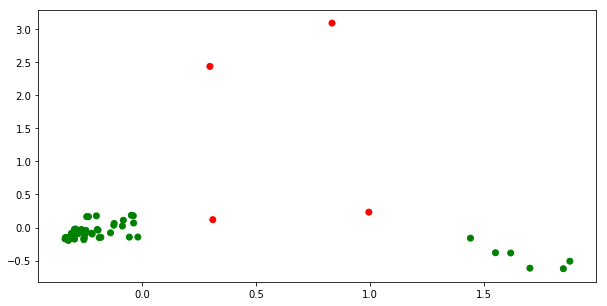

In [42]:
plot_anomaly(new_data)

## Alogrithem 2: Isolation Forest

In [43]:
outliers_fraction = 0.05

isoforest = IsolationForest(behaviour='new', contamination=outliers_fraction, random_state=42)
print(X_train.shape)
isoforest.fit(X_train)

df_result_IF = raw_data.copy()
df_result_IF['anomaly'] = isoforest.predict(X_train)
df_result_IF['anomaly'] = np.where(df_result_IF['anomaly'] == 1, 0, 1)

df_result_IF[df_result_IF['anomaly']==1]


(62, 44)


,index,iobjectid,jobdate,terminationflag,terminationtype,contractstartdateorig,contractenddate,lastknownododate,builddate,customertopnode,make,model,vehicledesc,bodytype,serviceorderid,accountingindicator,serviceinterval,odometer,supplierpostcode,industry_desc,industry_code,contractserviceitem,servicetype,productshorttext,quantity,supplier_srt,partscost,labourcost,costexcgst,totalcostbyserviceorder,anomaly
15,15,161531,26JUL2011,#,Not assigned,23OCT2009,22OCT2012,06SEP2012,01SEP2009,1000004617,Toyota,Hiace,Hiace 2.7P LWB Van A,Van,2801369140,Budget,80000.000,80328,4551,Construction: Building - General Contrac,1515.000,Maintenance Budgeted Premium,Wear & Tear,FUEL FILTER,1 ST,0.000,142.710,0.000,142.710,405.410,1
47,47,161531,11APR2012,#,Not assigned,23OCT2009,22OCT2012,06SEP2012,01SEP2009,1000004617,Toyota,Hiace,Hiace 2.7P LWB Van A,Van,2801881685,Budget,nan,110752,4551,Construction: Building - General Contrac,1515.000,Misc Operating Costs Budget,Wear & Tear,TRAILER PLUG,1 ST,1.000,16.700,82.500,99.200,99.200,1
60,60,161538,29AUG2012,#,Not assigned,04SEP2008,03NOV2012,04SEP2012,01APR2008,1000004428,Holden,Astra,AH Astra CD 5dr Wago,Station Wagon,2802136575,Budget,nan,38048,3043,Services: Social Services,8083.000,Maintenance Budgeted Premium,Wear & Tear,GLOBE - BRAKE LIGHT RIGHT,1 ST,0.200,3.760,15.600,19.360,19.360,1
61,99,161550,05MAY2011,#,Not assigned,26MAY2008,25MAY2012,01APR2015,01DEC2007,1000003639,Toyota,Hilux,Hilux 4WD 4.0P SR DC,Pick-Up,2800297501,Budget,50000.000,52712,2526,Transport and Communications: Electricit,4049.000,Maintenance Budgeted Premium,Scheduled,ENGINE OIL,1 L,0.000,33.000,0.000,33.000,159.260,1


In [44]:
new_data['anomaly'] = df_result_IF['anomaly']
new_data[new_data['anomaly']==1]


,partscost,supplier_srt,costexcgst,odometer,totalcostbyserviceorder,index,labourcost,contract_duration_days,car_age_days,cost_ratio,quantity,contractserviceitem_Misc Operating Costs Budget,contractserviceitem_Service Plan,model_Hiace,model_Hilux,productshorttext_DIFF OIL,productshorttext_ENGINE OIL,productshorttext_ENVIRONMENTAL LEVY,productshorttext_FUEL FILTER,productshorttext_GEAR OIL,productshorttext_GLOBE - BRAKE LIGHT RIGHT,productshorttext_OIL FILTER,productshorttext_SCH_SRV_TOYOTA_061,productshorttext_SERVICE BRAKE FLUID,productshorttext_SPARK PLUGS,productshorttext_TOYOTA ADVANTAGE SERVICE,productshorttext_TRAILER PLUG,productshorttext_VEHICLE INSPECTION,productshorttext_WASHER - SUMP PLUG,productshorttext_WASHER ADDITIVE,productshorttext_WHEEL ALIGNMENT - TOE,productshorttext_WHEEL BALANCE X 2,productshorttext_WORKSHOP SUPPLIES,industry_desc_Services: Social Services,industry_desc_Transport and Communications: Electricit,servicetype_Wear & Tear,make_Toyota,bodytype_Station Wagon,bodytype_Van,unmatched_total_1,supplierpostcode_30,supplierpostcode_45,industry_code_4049.0,industry_code_8083.0,pca1,pca2,anomaly
15,1.000,0.000,1.000,0.514,1.000,0.152,0.000,0.000,0.000,0.352,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.309,0.119,1
47,0.117,0.625,0.695,0.885,0.207,0.475,0.625,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,0.995,0.233,1
60,0.026,0.125,0.136,0.000,0.000,0.606,0.118,1.000,0.809,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,0.833,3.089,1
61,0.231,0.000,0.231,0.178,0.362,1.000,0.000,0.857,1.000,0.207,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,1.000,0.000,0.000,1.000,0.000,0.000,1.000,0.000,0.296,2.434,1


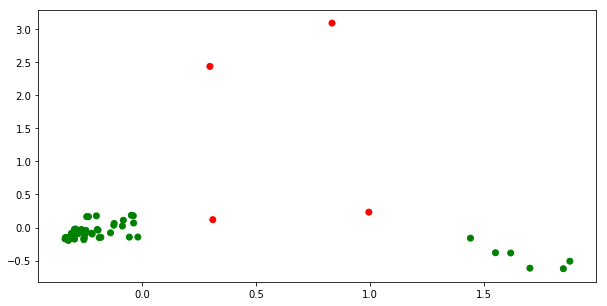

In [45]:
plot_anomaly(new_data)

## Interpretation

From the result both models are able to identify outlier based on reduced dimentionality dataset.

Given the limited sample size, the following can be summurized:
- For Index [15, 47, 60], the model is able to pick up some unscheduled maintenance 'Wear & Tear', and high `new_data.cost_ratio`

- For index [61], which is a scheduled maintence, it has unmatched total, i.e. sum of costexcgst not equal to totalcostbyserviceorder. This can be identified with `new_data.unmatched_total_1=1`


## Save Model

In [46]:
# save model
import pickle
with open('model.pkl', 'wb') as out:
    pickle.dump(isoforest, out, protocol=3) # python3 default
  

## Deploy Endpoint

Take note that the following needs to be updated according:
- image name
- classic model location
- sagemaker role arn
- endpoint name

In [34]:
import sagemaker
import uuid

# Get arguments for deploy script
image_name = 'leaseplan-deploy-py3'
model_path = 'classic-model/leaseplan-deploy-py3/input/model.tar.gz'
role_arn = sagemaker.get_execution_role()
endpoint_name = image_name + '-' + str(uuid.uuid4())[:8]

In [35]:
!sh ./deploy.sh $image_name s3://$bucket/$model_path $role_arn $endpoint_name

model.pkl
move: ./model.tar.gz to s3://sagemaker-ap-southeast-2-013615763154/classic-model/leaseplan-deploy-py3/input/model.tar.gz
013615763154
WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded
Sending build context to Docker daemon  2.779MB
Step 1/10 : FROM 520713654638.dkr.ecr.ap-southeast-2.amazonaws.com/sagemaker-tensorflow-scriptmode:1.12-cpu-py3
 ---> ba542f0b9706
Step 2/10 : RUN apt-get -y update && apt-get install -y --no-install-recommends          wget          nginx          ca-certificates     && rm -rf /var/lib/apt/lists/*
 ---> Using cache
 ---> 8ec8841e485d
Step 3/10 : RUN pip3 install --upgrade pip
 ---> Using cache
 ---> dbaed9cf4857
Step 4/10 : RUN pip3 install numpy scipy scikit-learn==0.20.3 pandas flask g

In [37]:
!aws sagemaker list-endpoints --name-contains $endpoint_name

{
    "Endpoints": [
        {
            "EndpointName": "leaseplan-deploy-py3-e26e31fb",
            "EndpointArn": "arn:aws:sagemaker:ap-southeast-2:013615763154:endpoint/leaseplan-deploy-py3-e26e31fb",
            "CreationTime": 1571227585.718,
            "LastModifiedTime": 1571227585.718,
            "EndpointStatus": "Creating"
        }
    ]
}


## Inference

Wait for endpoint to be available

In [38]:
import io, boto3, time

sess = boto3.Session()
sm = sess.client('sagemaker')
            
resp = sm.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
print("Status: " + status)

while status=='Creating':
    time.sleep(60)
    resp = sm.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']
    print("Status: " + status)

Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: InService


Load the some training data and invoke the endpoint

In [50]:
with open(train_filename, 'r') as f:
    payload = f.read()

In [55]:
import io, boto3

sess = boto3.Session()
response = sess.client('sagemaker-runtime').invoke_endpoint(
    EndpointName=endpoint_name, 
    Body=payload,
    ContentType='text/csv', 
)

results = response['Body'].read().decode('ascii')
results = results.split('\n')[:-1]
preds_df = pd.DataFrame(results, columns=['anomaly'])
preds_df['anomaly'] = np.where(preds_df['anomaly'] == '1', 0, 1)


In [56]:
df_result = raw_data.copy()
df_result['anomaly'] = preds_df['anomaly']

df_result[df_result['anomaly']==1]

,index,iobjectid,jobdate,terminationflag,terminationtype,contractstartdateorig,contractenddate,lastknownododate,builddate,customertopnode,make,model,vehicledesc,bodytype,serviceorderid,accountingindicator,serviceinterval,odometer,supplierpostcode,industry_desc,industry_code,contractserviceitem,servicetype,productshorttext,quantity,supplier_srt,partscost,labourcost,costexcgst,totalcostbyserviceorder,anomaly
47,47,161531,11APR2012,#,Not assigned,23OCT2009,22OCT2012,06SEP2012,01SEP2009,1000004617,Toyota,Hiace,Hiace 2.7P LWB Van A,Van,2801881685,Budget,nan,110752,4551,Construction: Building - General Contrac,1515.000,Misc Operating Costs Budget,Wear & Tear,TRAILER PLUG,1 ST,1.000,16.700,82.500,99.200,99.200,1
59,59,161531,12JUL2012,#,Not assigned,23OCT2009,22OCT2012,06SEP2012,01SEP2009,1000004617,Toyota,Hiace,Hiace 2.7P LWB Van A,Van,2802053131,Budget,120000.000,120241,4551,Construction: Building - General Contrac,1515.000,Service Plan,Scheduled,SCH_SRV_TOYOTA_061,1 ST,1.500,0.000,123.750,123.750,216.220,1
60,60,161538,29AUG2012,#,Not assigned,04SEP2008,03NOV2012,04SEP2012,01APR2008,1000004428,Holden,Astra,AH Astra CD 5dr Wago,Station Wagon,2802136575,Budget,nan,38048,3043,Services: Social Services,8083.000,Maintenance Budgeted Premium,Wear & Tear,GLOBE - BRAKE LIGHT RIGHT,1 ST,0.200,3.760,15.600,19.360,19.360,1
61,99,161550,05MAY2011,#,Not assigned,26MAY2008,25MAY2012,01APR2015,01DEC2007,1000003639,Toyota,Hilux,Hilux 4WD 4.0P SR DC,Pick-Up,2800297501,Budget,50000.000,52712,2526,Transport and Communications: Electricit,4049.000,Maintenance Budgeted Premium,Scheduled,ENGINE OIL,1 L,0.000,33.000,0.000,33.000,159.260,1


In [53]:
df_result['anomaly'].value_counts()

0    58
1     4
Name: anomaly, dtype: int64

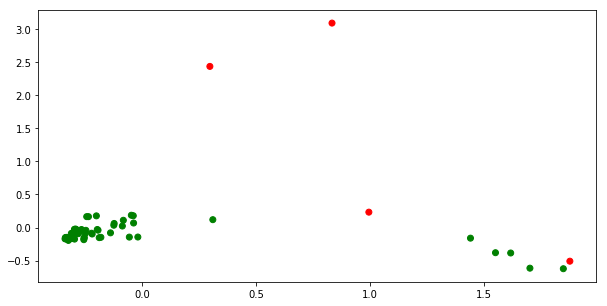

In [54]:
new_data['anomaly'] = df_result['anomaly']
plot_anomaly(new_data)


## Delete Endpoint

In [ ]:
#sm.delete_endpoint(EndpointName=endpoint_name)